# PURPOSE
* The purpose of this notebook is to compare four models that will be used to predict if an employee quits or not.
* Two models will be logistic regression
* Two models will be XGBoost classifiers
* One of each model types will be weighted and unweighted
* The goal of this notebook is to compare a linear model to a non-linear model and to see if class weights improve the outcome for these models
* The metric chosen for comparison is log-loss
* There will not be hyperparameter tuning conducted.  
* Brandon Johnson

In [43]:
print('Test Results')
results

Test Results


,Models,Log-Loss
0,Log NW,7.737371
1,Log CW,8.530331
2,XGBC NW,0.552669
3,XGBC CW,0.504611


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import StratifiedKFold, cross_validate, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, log_loss
from sklearn.utils.class_weight import compute_sample_weight

from xgboost import XGBClassifier

from feature_engine.encoding import OneHotEncoder

# DATA

In [6]:
seed = 1

In [7]:
df1 = pd.read_csv('HR_comma_sep.csv')
df1.sample(5)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,promotion_last_5years,departments,salary,quit
11225,0.82,0.49,5,203,6,0,0,technical,low,0
1725,0.10,0.86,5,253,4,0,0,technical,low,1
7718,0.93,0.76,3,212,3,0,0,sales,medium,0
13443,0.65,0.85,4,201,10,0,0,support,low,0
13353,0.13,0.90,5,264,6,0,0,technical,high,0


In [8]:
df1.columns

Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'work_accident',
       'promotion_last_5years', 'departments', 'salary', 'quit'],
      dtype='object')

In [9]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   work_accident          14999 non-null  int64  
 6   promotion_last_5years  14999 non-null  int64  
 7   departments            14999 non-null  object 
 8   salary                 14999 non-null  object 
 9   quit                   14999 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [10]:
df1.quit.value_counts()

0    11428
1     3571
Name: quit, dtype: int64

In [11]:
df1.quit.value_counts(normalize=True)

0    0.761917
1    0.238083
Name: quit, dtype: float64

In [12]:
df1.departments.value_counts()

sales          4140
technical      2720
support        2229
IT             1227
product_mng     902
marketing       858
RandD           787
accounting      767
hr              739
management      630
Name: departments, dtype: int64

In [13]:
df1.promotion_last_5years.value_counts()

0    14680
1      319
Name: promotion_last_5years, dtype: int64

In [14]:
df1.time_spend_company.value_counts()

3     6443
2     3244
4     2557
5     1473
6      718
10     214
7      188
8      162
Name: time_spend_company, dtype: int64

In [15]:
df1.salary.value_counts()

low       7316
medium    6446
high      1237
Name: salary, dtype: int64

In [16]:
df2 = df1.copy()

cat_columns = ['departments','salary']

df3_encoded = OneHotEncoder(variables=cat_columns, drop_last=False, ignore_format=True).fit_transform(df2)

df3_encoded.sample(10)

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,work_accident,promotion_last_5years,quit,departments_sales,departments_accounting,...,departments_technical,departments_support,departments_management,departments_IT,departments_product_mng,departments_marketing,departments_RandD,salary_low,salary_medium,salary_high
10827,0.65,0.98,3,252,2,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
9605,0.55,0.87,3,241,4,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
9586,0.96,1.00,4,167,2,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
13775,0.66,0.50,3,139,10,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
3154,0.87,0.52,3,158,2,1,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
12672,0.46,0.57,2,154,3,0,0,1,0,0,...,0,0,0,1,0,0,0,1,0,0
751,0.46,0.45,2,138,3,0,1,1,0,0,...,0,0,0,1,0,0,0,1,0,0
7429,0.76,0.58,3,262,2,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2736,0.74,0.64,4,101,6,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
9482,0.63,0.88,4,260,2,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0


**Variables dropped last were:**
* Departments - RandD
* Salary - High

# VISUALIZATION

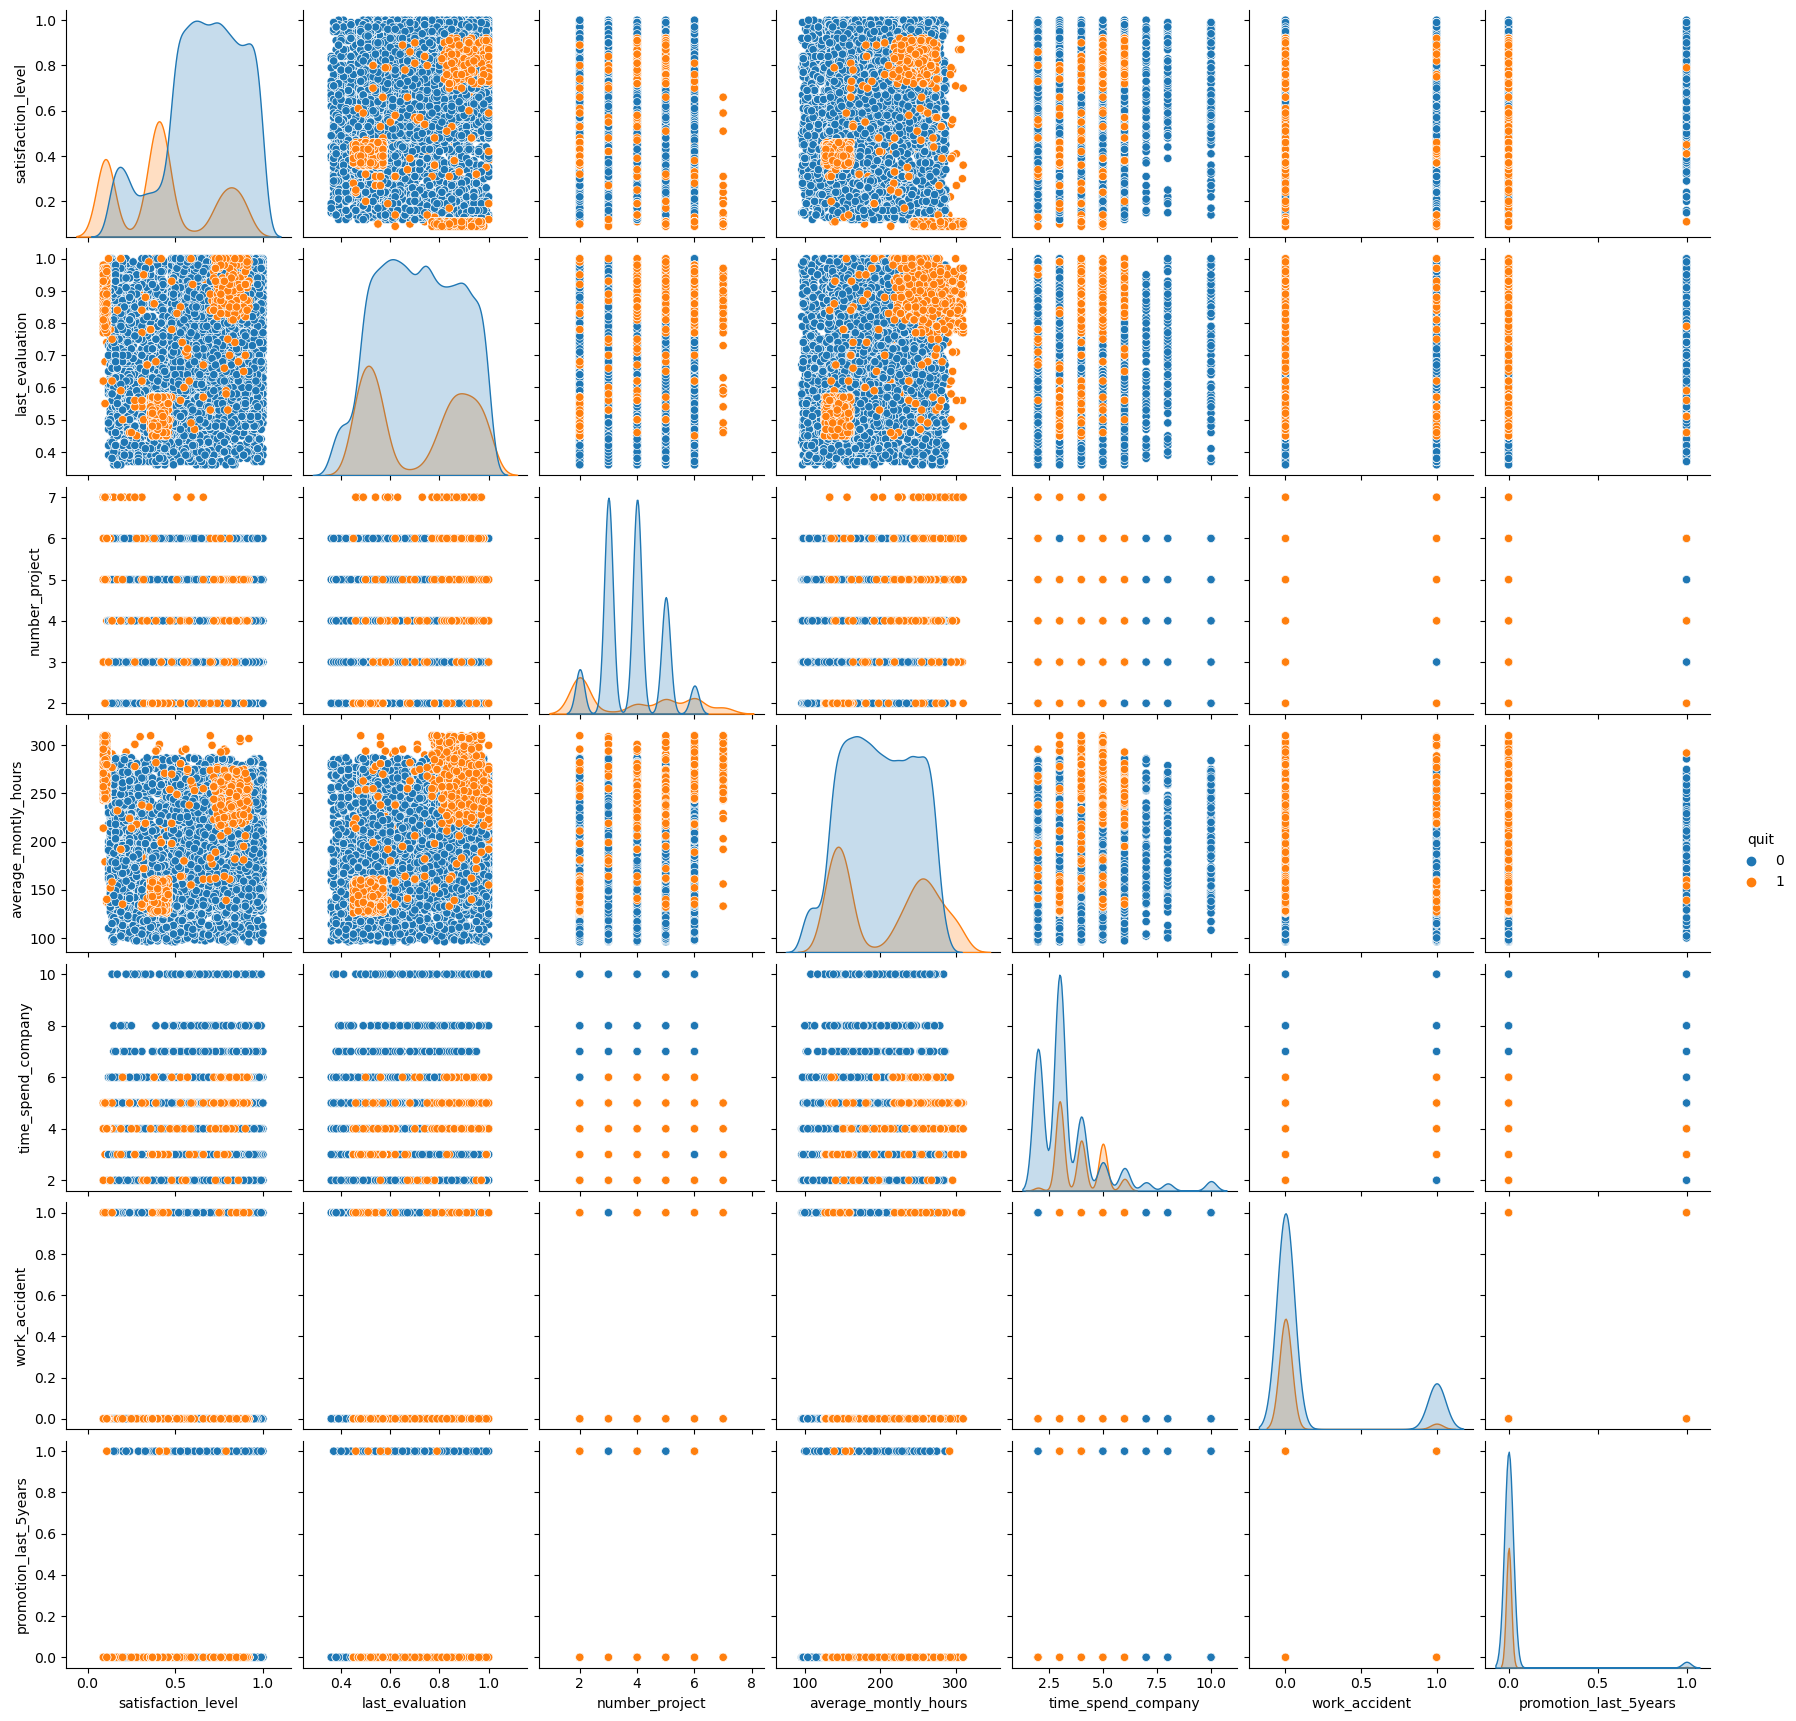

In [17]:
sns.pairplot(df1,hue='quit')
plt.show()

**No obvious linear patterns**

# MODEL 1 - PREDICTING QUIT OR NOT - NO SAMPLE WEIGHT

In [18]:
df3_encoded = OneHotEncoder(variables=cat_columns, drop_last=False, ignore_format=True).fit_transform(df2)
X = df3_encoded.drop('quit',axis=1)
y = df3_encoded.quit

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=seed, stratify=y)

print('X_train: ',X_train.shape)
print('X_test: ',X_test.shape)
print('y_train: ',y_train.shape)
print('y_test: ',y_test.shape)

X_train:  (13499, 20)
X_test:  (1500, 20)
y_train:  (13499,)
y_test:  (1500,)


In [19]:
log_reg = LogisticRegression(max_iter=10000, random_state=seed)

cv = StratifiedKFold(n_splits=5,random_state=seed, shuffle=True)

cv_log = cross_validate(estimator=log_reg, X=X_train,y=y_train, scoring='neg_log_loss', cv=cv, n_jobs=-1, )

In [20]:
cv_log_mean_log_loss1 = cv_log['test_score'].mean()*-1
cv_log_mean_log_loss1

0.43082938565020507

In [21]:
log_reg.fit(X_train,y_train)

y_train_preds = log_reg.predict(X_train)

print(classification_report(y_true=y_train, y_pred=y_train_preds))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87     10285
           1       0.60      0.34      0.43      3214

    accuracy                           0.79     13499
   macro avg       0.71      0.63      0.65     13499
weighted avg       0.77      0.79      0.77     13499



<AxesSubplot: >

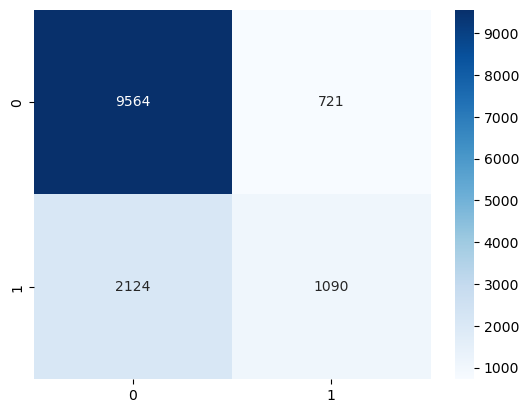

In [22]:
cm_log = confusion_matrix(y_true=y_train, y_pred=y_train_preds)

sns.heatmap(cm_log, annot=True, cmap='Blues',fmt='.0f')

In [23]:
y_test_preds1 = log_reg.predict(X_test)

log1_log_loss_test = log_loss(y_true=y_test,y_pred=y_test_preds1)
log1_log_loss_test

7.737370927530481

# MODEL 2 - PREDICTING QUIT OR NOT - SAMPLE WEIGHT

In [24]:
log_reg2 = LogisticRegression(max_iter=10000, random_state=seed, class_weight='balanced')

cv = StratifiedKFold(n_splits=5,random_state=seed, shuffle=True)

cv_log = cross_validate(estimator=log_reg2, X=X_train,y=y_train, scoring='neg_log_loss', cv=cv, n_jobs=-1, )

cv_log_mean_log_loss2 = cv_log['test_score'].mean()*-1
cv_log_mean_log_loss2

0.5377889027772526

In [25]:
log_reg2.fit(X_train,y_train)

y_train_preds2 = log_reg2.predict(X_train)

print(classification_report(y_true=y_train, y_pred=y_train_preds2))

              precision    recall  f1-score   support

           0       0.92      0.75      0.83     10285
           1       0.50      0.80      0.61      3214

    accuracy                           0.76     13499
   macro avg       0.71      0.77      0.72     13499
weighted avg       0.82      0.76      0.78     13499



<AxesSubplot: >

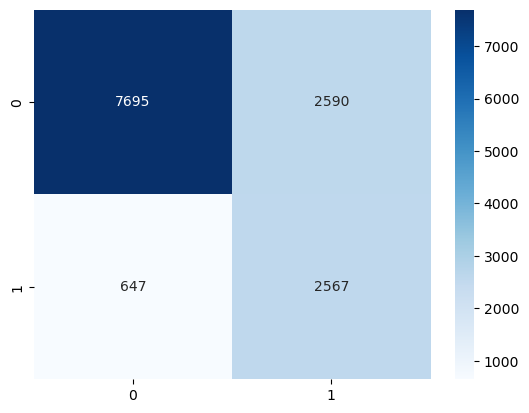

In [26]:
cm_log2 = confusion_matrix(y_true=y_train, y_pred=y_train_preds2)

sns.heatmap(cm_log2, annot=True, cmap='Blues',fmt='.0f')

In [27]:
y_test_preds2 = log_reg2.predict(X_test)

log2_log_loss_test = log_loss(y_true=y_test,y_pred=y_test_preds2)
log2_log_loss_test

8.53033130209106

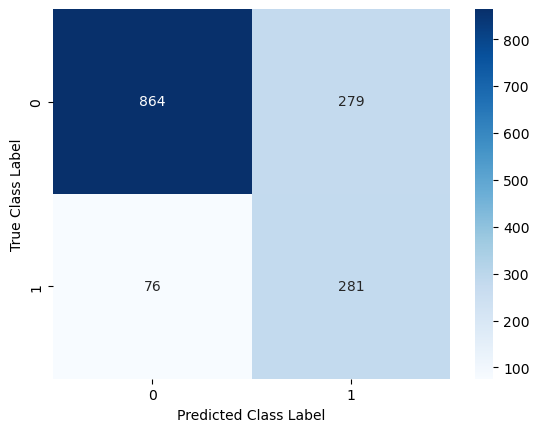

In [28]:
cm_log2_test = confusion_matrix(y_true=y_test, y_pred=y_test_preds2)

# plt.figure(figsize=(5,4),dpi=500)
sns.heatmap(cm_log2_test, annot=True, cmap='Blues',fmt='.0f')
plt.ylabel('True Class Label')
plt.xlabel("Predicted Class Label")
plt.show()

# MODEL 3 - XGBOOST1 - NO SAMPLE WEIGHT

In [29]:
xgbc1 = XGBClassifier(n_jobs=-1)

cv = StratifiedKFold(n_splits=5,random_state=seed, shuffle=True)

cv_xgbc1 = cross_validate(estimator=xgbc1, X=X_train,y=y_train, scoring='neg_log_loss', cv=cv, n_jobs=-1, )

cv_log_mean_log_loss3 = cv_xgbc1['test_score'].mean()*-1
cv_log_mean_log_loss3

0.057015539617809544

In [30]:
xgbc1.fit(X_train,y_train)

y_train_preds3 = xgbc1.predict(X_train)

print(classification_report(y_true=y_train, y_pred=y_train_preds3))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10285
           1       1.00      0.99      0.99      3214

    accuracy                           1.00     13499
   macro avg       1.00      0.99      1.00     13499
weighted avg       1.00      1.00      1.00     13499



<AxesSubplot: >

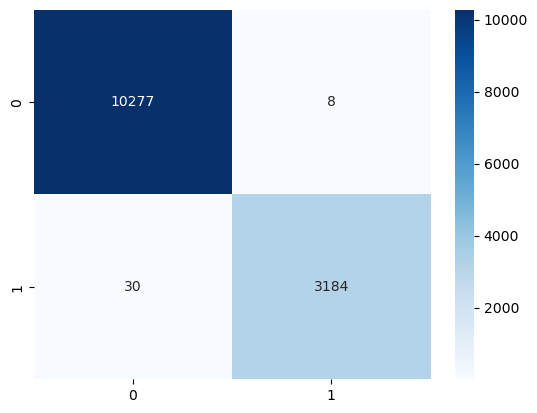

In [31]:
cm_xgbc1 = confusion_matrix(y_true=y_train, y_pred=y_train_preds3)

sns.heatmap(cm_xgbc1, annot=True, cmap='Blues',fmt='.0f')

In [32]:
y_test_preds3 = xgbc1.predict(X_test)

log1_xgbc_loss_test = log_loss(y_true=y_test,y_pred=y_test_preds3)
log1_xgbc_loss_test

0.5526693519664632

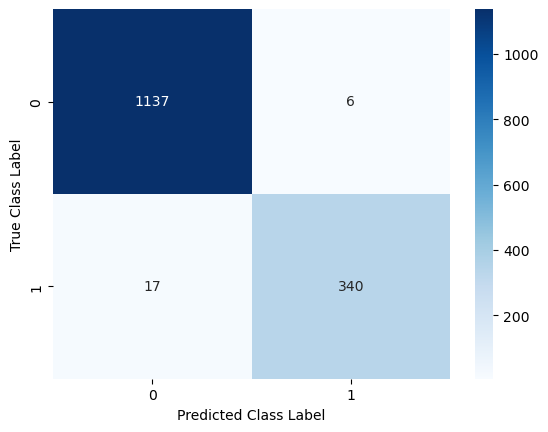

In [33]:
cm_xgbc1_test = confusion_matrix(y_true=y_test, y_pred=y_test_preds3)

# plt.figure(figsize=(5,4),dpi=500)
sns.heatmap(cm_xgbc1_test, annot=True, cmap='Blues',fmt='.0f')
plt.ylabel('True Class Label')
plt.xlabel("Predicted Class Label")
plt.show()

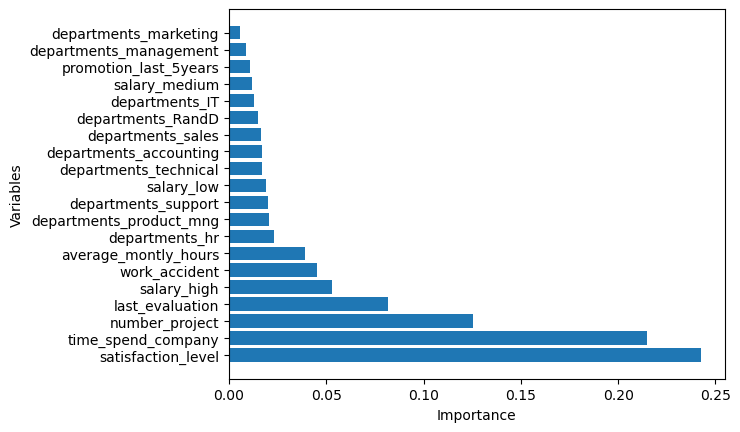

In [34]:
feat_imp = pd.DataFrame(zip(df3_encoded.drop('quit',axis=1).columns,xgbc1.feature_importances_),columns=['feature','importance']).sort_values(by='importance',ascending=False)


# plt.figure(figsize=(5,4),dpi=500)
plt.barh(y=feat_imp.feature, width=feat_imp.importance)
# plt.xticks(rotation=90)
plt.xlabel('Importance')
plt.ylabel('Variables')
plt.show()

# MODEL 4 - XGBOOST1 - SAMPLE WEIGHT

In [35]:
counts = y_train.value_counts().values

In [36]:
weight = counts[0]/counts[1]

xgbc2 = XGBClassifier(n_jobs=-1,scale_pos_weight=weight)

cv = StratifiedKFold(n_splits=5,random_state=seed, shuffle=True)

cv_xgbc2 = cross_validate(estimator=xgbc2, X=X_train,y=y_train, scoring='neg_log_loss', cv=cv, n_jobs=-1, )

cv_log_mean_log_loss4 = cv_xgbc2['test_score'].mean()*-1
cv_log_mean_log_loss4

0.0577336574510981

In [37]:
xgbc2.fit(X_train,y_train)

y_train_preds4 = xgbc1.predict(X_train)

print(classification_report(y_true=y_train, y_pred=y_train_preds4))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     10285
           1       1.00      0.99      0.99      3214

    accuracy                           1.00     13499
   macro avg       1.00      0.99      1.00     13499
weighted avg       1.00      1.00      1.00     13499



<AxesSubplot: >

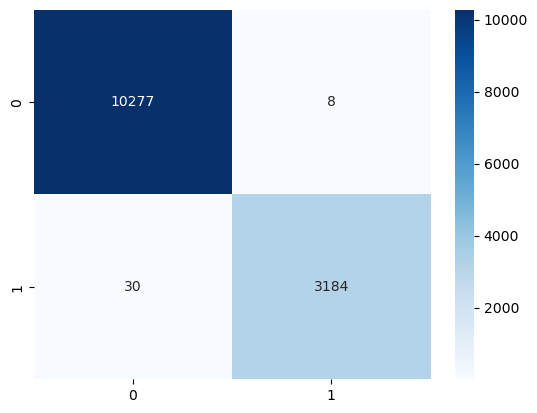

In [38]:
cm_xgbc2 = confusion_matrix(y_true=y_train, y_pred=y_train_preds4)

sns.heatmap(cm_xgbc2, annot=True, cmap='Blues',fmt='.0f')

In [39]:
y_test_preds4 = xgbc2.predict(X_test)

log2_xgbc_loss_test = log_loss(y_true=y_test,y_pred=y_test_preds4)
log2_xgbc_loss_test

0.5046111474476404

# CONCLUSION
* NW = No Class Weights
* CW = Class Weights Used

In [42]:
scores = [log1_log_loss_test,log2_log_loss_test,log1_xgbc_loss_test,log2_xgbc_loss_test]
models = ['Log NW','Log CW','XGBC NW','XGBC CW']

results = pd.DataFrame()
results['Models'] = models
results['Log-Loss'] = scores

print('Test Results')
results

Test Results


,Models,Log-Loss
0,Log NW,7.737371
1,Log CW,8.530331
2,XGBC NW,0.552669
3,XGBC CW,0.504611
